In [140]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
%matplotlib inline
import imageio

/tmp/ipykernel_78535/3759037990.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_data = imageio.imread('SampleImages/cat256.jpg')


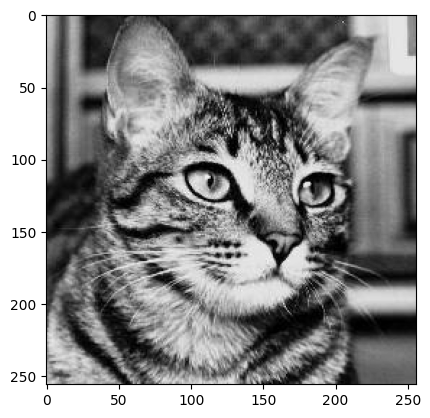

In [141]:
# # Load the .mat file into a dictionary
# mat_data = scipy.io.loadmat('SampleImages/peppers512.mat')

# # Extract the image data from the dictionary
# image_data = mat_data['peppers512']

image_data = imageio.imread('SampleImages/cat256.jpg')

image_data = image_data.astype(np.int16)

# Display the image using Matplotlib
plt.imshow(image_data, cmap='gray')
plt.axis('on')
plt.show()


In [142]:
# Separate image into 8x8 blocks
block_size = 8
blocks = []
for i in range(0, image_data.shape[0], block_size):
    for j in range(0, image_data.shape[1], block_size):
        blocks.append(image_data[i:i+block_size, j:j+block_size])

# Convert blocks to numpy array
print(blocks[589])
blocks = np.array(blocks)
blocks = blocks - 128

print(blocks.shape)
print(blocks[589])

[[ 83  98  34  83  35  55  39 104]
 [ 60 101 128  92  94  33  83 133]
 [ 11  23  44  61  96  98 130 123]
 [ 36   0  35 130  51 111 132  59]
 [ 32  42  30  72  85 115 139 163]
 [ 84  26  18  53  32  83 150 135]
 [102 109 112 150 107 139 160 150]
 [117 140 126 117 127 132 135 119]]
(1024, 8, 8)
[[ -45  -30  -94  -45  -93  -73  -89  -24]
 [ -68  -27    0  -36  -34  -95  -45    5]
 [-117 -105  -84  -67  -32  -30    2   -5]
 [ -92 -128  -93    2  -77  -17    4  -69]
 [ -96  -86  -98  -56  -43  -13   11   35]
 [ -44 -102 -110  -75  -96  -45   22    7]
 [ -26  -19  -16   22  -21   11   32   22]
 [ -11   12   -2  -11   -1    4    7   -9]]


In [143]:
#Apply 2 dimensional DCT to each block

dct_blocks = []
for i in range(blocks.shape[0]):
    dct_blocks.append(scipy.fftpack.dctn(blocks[i], norm='ortho'))
dct_blocks = np.array(dct_blocks)

print(dct_blocks.shape)
print(dct_blocks[589])

(1024, 8, 8)
[[-3.12000000e+02 -1.61939285e+02  3.50553624e+01 -2.43926669e+01
   1.20000000e+01  4.01168088e+01 -2.64267207e+01 -3.16078707e+01]
 [-1.32184789e+02  2.41152594e+01 -7.01458732e+00 -4.04382990e+01
   2.54902419e+01 -2.90265990e+01  3.20763038e-03 -1.18946807e-01]
 [ 9.05985700e+01  1.32535196e+02  1.57781746e+01 -3.56316803e+01
   3.26640741e-01 -5.73842307e+01  4.45436483e-01  3.56357352e-01]
 [-4.90164693e+01  1.25938638e-01  7.67594091e+01  3.43855426e-01
   2.59747252e+01  1.73412303e-01  5.81607393e-01 -3.10263501e+01]
 [-1.80000000e+01  2.23036239e+01 -1.90380176e+01  2.85038247e+01
   5.00000000e-01 -6.29222144e-02 -2.32136427e-01 -3.95199491e+01]
 [-1.25108619e+01 -1.83804987e-01 -2.77190221e+01  3.14987911e+01
  -2.28070197e-02  5.20482802e+01 -1.86694178e-01 -4.61093427e+01]
 [-7.45990893e+01 -3.18140697e+01  3.84454365e+01  4.41417819e+01
   1.35299025e-01  2.18870362e-01  2.21825407e-01  2.19989112e-01]
 [ 3.55657225e+01 -4.62935680e+01 -2.17813916e-01 -2.381

In [144]:
# Quantize the DCT coefficients

quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])

quality_factor = 80

if quality_factor > 50:
    scale = (100 - quality_factor) / 50
    quantization_matrix = quantization_matrix * scale
else:
    scale = 50 / quality_factor
    quantization_matrix = quantization_matrix * scale

quantized_dct_blocks = []


for x in dct_blocks:
    s = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s[i][j] = round(x[i][j] / quantization_matrix[i][j])
    quantized_dct_blocks.append(s)

quantized_dct_blocks = np.array(quantized_dct_blocks)

print(quantized_dct_blocks[589])


[[-49. -37.   9.  -4.   1.   3.  -1.  -1.]
 [-28.   5.  -1.  -5.   2.  -1.   0.   0.]
 [ 16.  25.   2.  -4.   0.  -3.   0.   0.]
 [ -9.   0.   9.   0.   1.   0.   0.  -1.]
 [ -2.   3.  -1.   1.   0.   0.   0.  -1.]
 [ -1.   0.  -1.   1.   0.   1.   0.  -1.]
 [ -4.  -1.   1.   1.   0.   0.   0.   0.]
 [  1.  -1.   0.   0.   0.  -1.   0.   0.]]


In [145]:
# Coding the DC coefficients

dc_coefficients = []
for x in quantized_dct_blocks:
    dc_coefficients.append(x[0][0])

# print(dc_coefficients)

# differential pulse code modulation for DC coefficients

dpcm_dc_coefficients = []
dpcm_dc_coefficients.append(dc_coefficients[0])
for i in range(1, len(dc_coefficients)):
    dpcm_dc_coefficients.append(dc_coefficients[i] - dc_coefficients[i-1])

# print(dpcm_dc_coefficients)

# run,level modulation for AC pairs

run_level_pairs_blocks = []

for x in quantized_dct_blocks:
    run = 0
    level = 0
    run_level_pairs = []
    for i in range(1, 8):
        for j in range(1, 8):
            if x[i][j] != 0:
                run_level_pairs.append((run, level))
                run = 0
                level = x[i][j]
            else:
                run += 1
                
    run_level_pairs_blocks.append(run_level_pairs)

    # Entropy coding for run-level pairs

entropy_coded_blocks = []

for x in run_level_pairs_blocks:
    entropy_coded_block = []
    for i in range(len(x)):
        if i == 0:
            entropy_coded_block.append((x[i][0], x[i][1]))
        else:
            if x[i][0] == 0 and x[i][1] == 0:
                entropy_coded_block.append((15, 0))
            else:
                entropy_coded_block.append((x[i][0], x[i][1]))
    entropy_coded_blocks.append(entropy_coded_block)


In [146]:
# inverse quantization

inverse_quantized_dct_blocks = []

for x in quantized_dct_blocks:
    s = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s[i][j] = x[i][j] * quantization_matrix[i][j]
    inverse_quantized_dct_blocks.append(s)

inverse_quantized_dct_blocks = np.array(inverse_quantized_dct_blocks)

print(inverse_quantized_dct_blocks.shape)
print(inverse_quantized_dct_blocks[589])

# perform inverse DCT

inverse_dct_blocks = []

for x in inverse_quantized_dct_blocks:
    inverse_dct_blocks.append(scipy.fftpack.idctn(x, norm='ortho'))
inverse_dct_blocks = np.array(inverse_dct_blocks)

print(inverse_dct_blocks.shape)
print(inverse_dct_blocks[589])

inverse_dct_blocks = inverse_dct_blocks + 128
inverse_dct_blocks = inverse_dct_blocks.astype(int)

print(inverse_dct_blocks.shape)
print(inverse_dct_blocks[589])



(1024, 8, 8)
[[-313.6 -162.8   36.   -25.6    9.6   48.   -20.4  -24.4]
 [-134.4   24.    -5.6  -38.    20.8  -23.2    0.     0. ]
 [  89.6  130.    12.8  -38.4    0.   -68.4    0.     0. ]
 [ -50.4    0.    79.2    0.    20.4    0.     0.   -24.8]
 [ -14.4   26.4  -14.8   22.4    0.     0.     0.   -30.8]
 [  -9.6    0.   -22.    25.6    0.    41.6    0.   -36.8]
 [ -78.4  -25.6   31.2   34.8    0.     0.     0.     0. ]
 [  28.8  -36.8    0.     0.     0.   -40.     0.     0. ]]
(1024, 8, 8)
[[ -47.2973649   -29.77018753  -84.38298194  -53.13679368  -93.29329134
   -79.17660941  -87.20976048  -24.37379837]
 [ -67.87530241  -33.02960718   -6.97104446  -35.17221664  -36.60964675
   -84.80593003  -40.26788968    3.01255963]
 [-115.90499726 -110.53696427  -82.25354747  -61.13431125  -38.6873781
   -32.64331253   -0.68945583  -12.74975121]
 [ -87.83959093 -129.10470903  -87.58767378   -2.95431279  -73.96286769
   -17.93489223    9.29437437  -61.26559932]
 [ -87.17866653  -93.65872866  -94

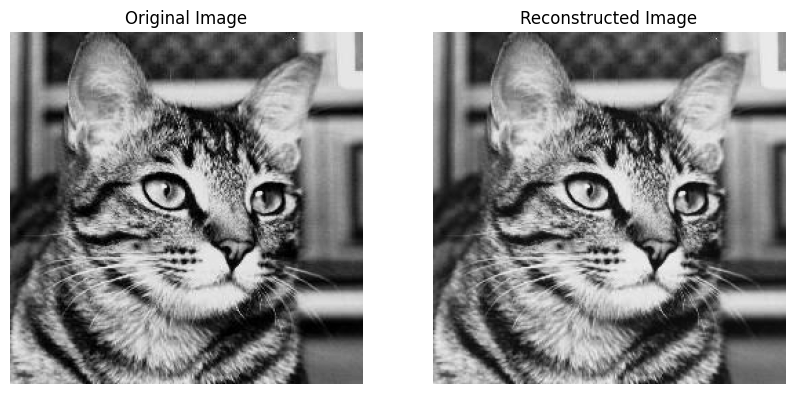

In [147]:
num_blocks = int(np.sqrt(inverse_dct_blocks.shape[0]))
block_size = inverse_dct_blocks.shape[1]

# Reshape the blocks array
blocks_reshaped = inverse_dct_blocks.reshape((num_blocks, num_blocks, block_size, block_size))

# Initialize an empty image
reconstructed_image = np.zeros((num_blocks * block_size, num_blocks * block_size))

# Reconstruct the image from blocks
for i in range(num_blocks):
    for j in range(num_blocks):
        reconstructed_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = blocks_reshaped[i, j, :, :]

# Visualize the images
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(image_data, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')
plt.show()




In [148]:
# find percentage of zeroes
num_zeroes = 0
for x in quantized_dct_blocks:
    for i in range(8):
        for j in range(8):
            if x[i][j] == 0:
                num_zeroes += 1
                
percentage_zeroes = num_zeroes / (quantized_dct_blocks.shape[0] * 64) * 100
print("Percentage of Zeroes : ",percentage_zeroes)

# two dimensional mean square error
error_matrix = image_data - reconstructed_image
mse = np.mean(np.square(error_matrix))
print("Mean Square Error : ",mse)

# calculate the peak signal to noise ratio  
psnr = 20 * np.log10((255) / np.sqrt(mse))
print("Peak Signal to Noise Ratio (PSNR) : ",psnr)


Percentage of Zeroes :  67.56744384765625
Mean Square Error :  5.52154541015625
Peak Signal to Noise Ratio (PSNR) :  40.71019712637013
